# Imports


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins import projector
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import datetime
from preprocess.pipelines import make_pipeline
from PIL import Image
import csv
from tqdm import tqdm as tqdm
import time
import json
import random


In [5]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:

%load_ext tensorboard

# Projection Head
The projection head will project the embeddings generated by the image and text encoders to a vector of the same size


In [7]:
def make_projection_head(embedding_size, projection_size,num_layers,dropout_rate,name='projection_head'):
    input=keras.Input(shape=(embedding_size))
    projection=layers.Dense(projection_size)(input)

    for i in range(num_layers): 
        x = tf.nn.gelu(projection)
        x = layers.Dense(projection_size)(x)
        x = layers.Dropout(dropout_rate)(x) 
        x = layers.Add()([projection,x])
        projection=layers.LayerNormalization()(x)
    return keras.Model(inputs=input,outputs=projection,name=name)
    

## Projection head overview

Model: "projection_head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 788)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          100992      ['input_1[0][0]']                
                                                                                                  
 tf.nn.gelu (TFOpLambda)        (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['tf.nn.gelu[0][0]']             
                                                                                    

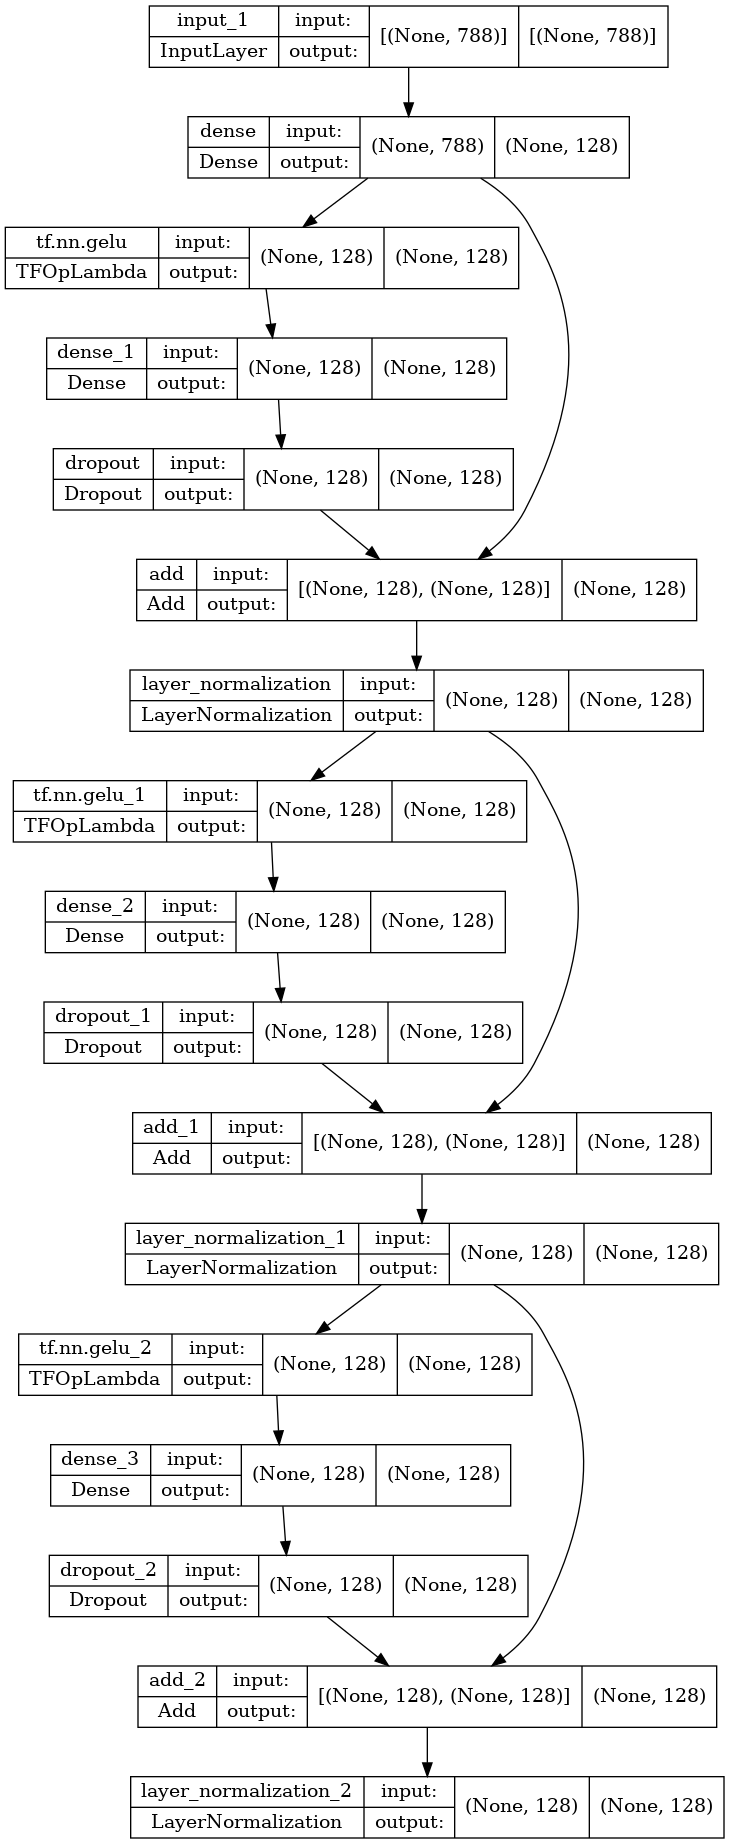

In [8]:
model=make_projection_head(788,128,3,0.2)
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)


# Text encoder
The text encoder uses BERT as a base model to generate embeddings. 
Link to model:  
https://tfhub.dev/google/collections/bert/1

The model is set to be either trainable or non trainable according to the experiment

In [9]:

def make_text_encoder(projection_size=128,
                      backbone='bert',
                      projection_layers=3,
                      dropout_rate=0.2,
                      trainable=False):
    
    if backbone=='bert':
        # Importing Bert
        preprocessor_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
        bert_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
        bert_preprocessor=hub.KerasLayer(preprocessor_url,name='bert_preprocessor')
        bert=hub.KerasLayer(bert_url,name='bert')

        # Set up Bert trainability
        bert.trainable=trainable

        # Building functional model
        inputs=tf.keras.Input(shape=(),dtype=tf.dtypes.string, name='text')
        x=bert_preprocessor(inputs)
        x=bert(x)['pooled_output']
    

    x=make_projection_head(embedding_size=x.shape[-1],
                           projection_size=projection_size,
                           num_layers=projection_layers,
                           dropout_rate=dropout_rate,
                           name='text_projection_head')(x)
    return tf.keras.Model(inputs=inputs,outputs=x,name='text_encoder')



In [10]:
model=make_text_encoder(projection_size=128,projection_layers=3,trainable=False)

2022-08-02 16:06:30.175323: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.50MiB (rounded to 1572864)requested by op Identity
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-08-02 16:06:30.175570: W tensorflow/core/common_runtime/bfc_allocator.cc:474] ******************************************************************xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

## Text encoder overview

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.input

# Image encoder



In [ ]:
def make_image_encoder( input_shape=(299,299,3),
                        projection_size=128,
                        projection_layers=3,
                        dropout_rate=0.2,
                        trainable=False, 
                        backbone='resnet50',
                        weights='imagenet',
                        backbone_pooling='avg'):
    # Set up the backbone
    if backbone=='xception':
        backbone_model=tf.keras.applications.Xception(
                include_top=False,
                weights=weights,
                pooling=backbone_pooling
        )
    if backbone=='resnet50':
        backbone_model=tf.keras.applications.ResNet50(
            include_top=False,
            weights=weights,
            pooling=backbone_pooling
        )

    # Set the trainability of the backbone
    for layer in backbone_model.layers:
        layer.trainable=trainable 
    
    # Functional model definition
    inputs=tf.keras.Input(shape=input_shape,name='image')
    x=backbone_model(inputs)
    x=make_projection_head(embedding_size=x.shape[-1],
                           projection_size=projection_size,
                           num_layers=projection_layers,
                           dropout_rate=dropout_rate,
                           name='image_projection_head')(x)
    return tf.keras.Model(inputs=inputs,outputs=x, name='image_encoder')



## Image encoder overview

In [ ]:
model=make_image_encoder(backbone='resnet50')

In [ ]:
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

# Dual Encoder

## Building model

In [ ]:
def clip_loss(caption_embeddings, image_embeddings,temperature=1):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True,name='image_sim'
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2
def make_dual_encoder(image_encoder,text_encoder,temperature=0.2):
    
    image_input=tf.keras.Input(tensor=image_encoder.input,name='image')
    text_input= tf.keras.Input(tensor=text_encoder.input,name='text')

    img_encoding=image_encoder(image_input)
    txt_encoding=text_encoder(text_input)

    
    model=tf.keras.Model(inputs=[image_input,text_input],outputs=[img_encoding,txt_encoding],name='clip')
    loss=clip_loss(txt_encoding,img_encoding)
    model.add_loss(loss)




    return model


# Train model with COCO

## Data input pipeline

In [ ]:
data,info=tfds.load(name='coco_captions',with_info=True)

In [ ]:
def get_image(dataset):
    img=dataset['image']
    img=img/255
    img=tf.image.resize(img,[299,299])
    return img
def get_capt(dataset):
    caption=dataset['captions']['text'][0]
    return caption

In [ ]:
imgs=data['train'].map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
capts=data['train'].map(get_capt,num_parallel_calls=tf.data.AUTOTUNE)
train_data=tf.data.Dataset.zip((imgs,capts))
train_data_nb=train_data
train_data=tf.data.Dataset.zip((train_data,)).shuffle(100).batch(64).prefetch(tf.data.AUTOTUNE)

imgs=data['test'].map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
capts=data['test'].map(get_capt,num_parallel_calls=tf.data.AUTOTUNE)
val_data=tf.data.Dataset.zip((imgs,capts))
val_data_nb=val_data
val_data=tf.data.Dataset.zip((val_data,)).shuffle(100).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
data_df=tfds.as_dataframe(ds=data['train'].take(1000))

## Training

Define a training scheduler

In [ ]:
def schedule(epoch):
    return 1e-6*10**(epoch/5)

Train the model

In [ ]:
#Args
data_pipeline =   make_pipeline('../data/intermediate/inter_medpix.csv',
                  image_size=(299, 299),downscale=True,
                  shuffle=True,
                  seed=1,fractions=[0.70,0.15,0.15]) 
embedding_size=60 
image_backbone='resnet50'
text_backbone='bert'
train_image_backbone=False
train_text_backbone=False
log_dir='../model_logs/pretraining/clip/'
save_model_path='../models/pretraining/clip/dual_encoder/'
debug=True
image_backbone='resnet50'
text_backbone='bert'
dropout_rate=0





#Inside function
# Get relevanta data
train_data= data_pipeline['CLIP']['train'].batch(32)
val_data= data_pipeline['CLIP']['val'].batch(32)
# Data to measure retrieval 
eval_img_paths=data_pipeline['CLIP']['train_img_paths'][0:32]
eval_queries=data_pipeline['CLIP']['train_captions'][0:32]

# Instantiate model 
img_encoder=make_image_encoder(input_shape=(299,299,3),backbone=image_backbone,
                               projection_layers=3,
                               projection_size=embedding_size,
                               dropout_rate=dropout_rate)
txt_encoder=make_text_encoder(projection_layers=3,
                              backbone=text_backbone,
                              projection_size=embedding_size,dropout_rate=0)

opt = keras.optimizers.Adam(learning_rate=4e-4)
clip=make_dual_encoder(img_encoder,txt_encoder)
clip.compile(opt)


# Get parameters for logging
params_log={'task': 'pretraining_clip',
            'text_backbone':text_backbone, 
            'image_backbone':image_backbone,
            'embedding_size':embedding_size,
            'train_image_backbone':train_image_backbone,
            'train_text_backbone':train_text_backbone,
            'debug':debug}



# Define callbacks 
# define save paths
date_str=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir=log_dir+date_str
save_model_path=save_model_path + date_str
image_encoder_savepath='../models/pretraining/clip/image_encoder/'+date_str
text_encoder_savepath='../models/pretraining/clip/text_encoder/'+date_str

# make callbacks
# custom callbacks 



class ClipCallback(tf.keras.callbacks.Callback):
    def __init__(self,eval_img_paths,eval_queries,k):
        """
        Args:
            eval_img_paths(list of str): The paths to images for retrieval evaluation. 
            eval_queries(list of str): The queries to evaluate retrieval. They must have matching 
                order to the eval_img_paths. 
            k(int): Number of retrievals for top_k_retrieval metric. 
        """
        
        super().__init__()
        self.eval_img_paths=eval_img_paths
        self.eval_queries=eval_queries 
        self.top_k_k=k
    def on_train_begin(self,logs=None):
        """
        Log the model parameters and name of the training dataset. 

        """
        file_writer = tf.summary.create_file_writer(log_dir) #+ "/model_params")
        file_writer.set_as_default()
        tf.summary.text("model_params", pretty_json(params_log), step=0)
    def on_epoch_end(self, epoch,logs):
        ''' 
        Save the image and text encoder, log top k retrieval metrics
        '''
        file_writer = tf.summary.create_file_writer(log_dir) #+ "/metrics")
        file_writer.set_as_default()
        if epoch%2==0:
            print('\n saving epoch checkpoint for img and text encoders')
            # img_encoder.save(image_encoder_savepath + '/epoch_'+str(epoch))
            # txt_encoder.save(text_encoder_savepath + + '/epoch_'+str(epoch) )
        print('\nevaluating eppoch retrieval')
        acc=top_k_accuracy(img_encoder,txt_encoder,self.eval_img_paths,self.eval_queries,k=self.top_k_k,batch_size=32)
        tf.summary.scalar('top_'+str(self.top_k_k)+'_accuracy', acc, step=epoch)
        
    # def on_train_end(self,logs=None):
    #     make_embeddings_projection(img_encoder,img_paths,img_paths,save_path='../projections')
            
            
            
            
epoch_end_callback=ClipCallback(eval_img_paths,eval_queries,10)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=save_model_path,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True)


            



if (debug==False):
    history=clip.fit(train_data,
                     epochs=30,
                     validation_data=val_data,
                     callbacks=[tensorboard_callback, checkpoint_callback,epoch_end_callback])
if (debug==True):
    print('training on debug portion of the dataset for few epochs')
    history=clip.fit(train_data.take(1),
                     epochs=100,
                     validation_data=val_data.take(1),
                     callbacks=[tensorboard_callback,
                                # checkpoint_callback,
                                epoch_end_callback])

Display training history

In [5]:

%tensorboard --logdir ../model_logs/pretraining/clip/

Save the text encoder and the image encoder

In [ ]:
save_path='/content/drive/MyDrive/MedClip/Models/Homemade clip/'
image_encoder_savepath='../models/pretraining/clip/image_encoder/'+date_str
text_encoder_savepath='../models/pretraining/clip/text_encoder/'+date_str


In [ ]:
img_encoder.save(image_encoder_savepath)
txt_encoder.save(text_encoder_savepath)

# Test the model

Load the encoders



In [ ]:
save_path='/content/drive/MyDrive/MedClip/Models/Homemade clip/'
image_encoder_savepath='../models/pretraining/clip/image_encoder/20220714-194250'
text_encoder_savepath='../models/pretraining/clip/text_encoder/20220714-193424'

In [ ]:
img_encoder=tf.keras.models.load_model(image_encoder_savepath)
txt_encoder=tf.keras.models.load_model(text_encoder_savepath)
# dual_encoder=tf.keras.models.load_model(save_path)

Generate the embeddings

In [ ]:
def get_images(d):
    return d['image']
def get_texts(d):
    return d['text']
def get_images_coco(d,i):
    return d
def get_texts_coco(d,i):
    return i

In [ ]:
images=train_data_nb.map(get_images_coco).take(1000).batch(128)
texts=train_data_nb.map(get_texts_coco).take(1000).batch(128)

In [ ]:
# images=data_pipeline['CLIP']['val'].map(get_images).batch(128)
# texts=data_pipeline['CLIP']['val'].map(get_texts).batch(128)
img_embeddings=img_encoder.predict(images,verbose=1)
txt_embeddings=txt_encoder.predict(texts,verbose=1)

In [ ]:
def decode_and_resize(img_path,image_size=(299,299),scale=1/255):
        """Recieves an image path, decodes and rescales it. """
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img*scale
        return img
    

In [ ]:
# images_dataset=tf.data.Dataset.from_tensor_slices(img_paths).map(lambda x:(decode_and_resize(x))).batch(64)
# image_embeddings = img_encoder.predict(images_dataset,verbose=1) 

In [ ]:
find_images(image_embeddings, txt_encoder, img_paths, ['some picture of something','hey'], k=5, normalize=True)

In [ ]:
def find_images(img_embeddings, txt_encoder, img_paths, query_strings, k=5, normalize=True,show=False):
    """ Finds an image that matches the given query """
    query = tf.convert_to_tensor(query_strings)
    # query = tf.reshape(query,[1])
    
    query = txt_encoder.predict(query, verbose=0)
    # images_dataset=tf.data.Dataset.from_tensor_slices(img_paths).map(lambda x:(decode_and_resize(x))).batch(64)
    # img_embeddings = img_encoder.predict(images_dataset,verbose=1) 
    if normalize:
        image_embeddings = tf.math.l2_normalize(img_embeddings, axis=1)
        query = tf.math.l2_normalize(query, axis=1)
    
    dot_similarity = tf.matmul(query, img_embeddings, transpose_b=True)
    results=tf.math.top_k(dot_similarity, k).indices.numpy()
    # print(results)
    
    matches=[]
    for i in range(len(results)):
        if show:
            print(f'Results for query:{query_strings[i]}')
        query_result=results[i]
        query_matches=[]
        for j in range(k): 
            path=img_paths[query_result[j]]
            if show:
                im = Image.open(path)
                display(im)
            query_matches.append(path)
        matches.append(query_matches)
    return matches
        

In [ ]:
def find_image_coco(query,k,img_embeddings,imgs_df,normalize=False):
    """ Finds an image that matches the given query """
    query=tf.convert_to_tensor(query)
    query=tf.reshape(query,[1])
    query=txt_encoder(query)
    print(query)
    
    if normalize:
        image_embeddings = tf.math.l2_normalize(img_embeddings, axis=1)
        query = tf.math.l2_normalize(query, axis=1)
    
    dot_similarity = tf.matmul(query, img_embeddings, transpose_b=True)
    results=tf.math.top_k(dot_similarity, k).indices.numpy()[0]
    print(results)
    for i in range(k): 
        matches=[]
        im=imgs_df['image'][results[i]]
        plt.imshow(im)
        plt.show
        matches.append(path)
    return matches
        

In [ ]:
def pretty_json(hp):
    json_hp = json.dumps(hp, indent=2)
    return "".join("\t" + line for line in json_hp.splitlines(True))

In [ ]:
find_image_coco('a nic evening',5,img_embeddings,data_df)

In [ ]:
data_df.head()

## Make a metric for top k retrieval

In [ ]:
img_paths=data_pipeline['CLIP']['train_img_paths']
queries=data_pipeline['CLIP']['train_captions']
batch_size=64

In [ ]:
top_k_accuracy(img_encoder,txt_encoder,img_paths,queries,k=10,batch_size=64)

In [ ]:
def top_k_accuracy(img_encoder,txt_encoder,img_paths,queries,k=10,batch_size=64):
    """
    Returns the top k
    """
    # Get the image embeddings for all provided images
    images_dataset=tf.data.Dataset.from_tensor_slices(img_paths).map(lambda x:(decode_and_resize(x))).batch(batch_size)
    img_embeddings = img_encoder.predict(images_dataset,verbose=1) 
    
    
    
    hits = 0
    num_batches = int(np.ceil(len(img_paths) / batch_size))
    for idx in tqdm(range(num_batches)):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_img_paths = img_paths[start_idx:end_idx]
        current_queries = queries[start_idx:end_idx]  
        result = find_images(img_embeddings,txt_encoder,img_paths, current_queries, k)
        hits += sum(
            [
                img_path in matches
                for (img_path, matches) in list(zip(current_img_paths, result))
            ]
        )

    return hits / len(img_paths)


In [ ]:
mylist=range(5)

In [ ]:
random.sample(mylist,4)

In [ ]:
def random_top_k_accuracy(n,k):
    """
    Returns the top k
    """
    imgs=range(n)
    hits=0
    for i in range(n):
        query=i
        # print('query', query)
        choices=random.sample(imgs,k)
        # print('choices', choices)
        for c in choices:
            
            if c==query:
                # print('hit')
                hits+=1
                break
    return hits/n
        
    

In [ ]:
a=[]
for i in range(10000):
    a.append(random_top_k_accuracy(32,10)*100)

In [ ]:
np.mean(a)

# Making tensorboard visualizations


Load the images we will be using for projection

In [ ]:
img_paths=img_paths[0:15]

In [ ]:
make_embeddings_projection(img_encoder,img_paths,img_paths,save_path='../projections_test2')

In [ ]:
def make_embeddings_projection(img_encoder,img_paths,labels,save_path):
    # Generate embeddings
    os.makedirs(save_path,exist_ok=True)
    images_pil = []
    images_embeddings = []
    for img_path in img_paths: 
        img_tf = decode_and_resize(img_path)
        # Save both tf image for prediction and PIL image for sprite
        img_pil = Image.open(img_path).resize((100, 100))
        img_embedding = img_encoder(tf.expand_dims(img_tf, axis=0))
        images_embeddings.append(img_embedding.numpy()[0])
        images_pil.append(img_pil)
        # Assuming your output data is directly the label
    
    # Write metadata of embeddings. 
    LOG_DIR=save_path
    with open(f'{LOG_DIR}/feature_vecs.tsv', 'w') as fw:
        csv_writer = csv.writer(fw, delimiter='\t')
        csv_writer.writerows(images_embeddings)
    one_square_size = int(np.ceil(np.sqrt(len(images_embeddings))))
    
    # Generate sprite
    master_width = 100 * one_square_size
    master_height = 100 * one_square_size
    spriteimage = Image.new(
        mode='RGBA',
        size=(master_width, master_height),
        color=(0,0,0,0) # fully transparent
    )
    for count, image in enumerate(images_pil):
        div, mod = divmod(count, one_square_size)
        h_loc = 100 * div
        w_loc = 100 * mod
        spriteimage.paste(image, (w_loc, h_loc))
    spriteimage.convert('RGB').save(f'{LOG_DIR}/sprite.jpg', transparency=0)
    
    # Write labels
    with open(f'{LOG_DIR}/metadata.tsv', 'w') as file: 
        for label in labels:
            file.write(f'{label}\n')
    # Write config file
    with open(f'{LOG_DIR}/projector_config.pbtxt', 'w') as file: 
        config="""embeddings {
  tensor_path: "feature_vecs.tsv"
  metadata_path: "metadata.tsv"

    sprite {
        image_path: "sprite.jpg"
        single_image_dim: 100
        single_image_dim: 100
  }
}"""
        file.write(config)

In [ ]:
data_pipeline =   make_pipeline('../data/intermediate/inter_medpix.csv',
                  image_size=(299, 299),downscale=True,
                  shuffle=True,
                  seed=1,fractions=[0.70,0.15,0.15]) 

image_paths=data_pipeline['CLIP']['val_img_paths'][0:10]# Contains the paths to the images
labels=[0]*len(image_paths)

Load de image encoder

In [ ]:
img_encoder=tf.keras.models.load_model(image_encoder_savepath)

In [ ]:
# Generate embeddings
images_pil = []
images_embeddings = []
labels = []
for img_path in image_paths: 
    img_tf = decode_and_resize(img_path)
    # Save both tf image for prediction and PIL image for sprite
    img_pil = Image.open(img_path).resize((100, 100))
    img_embedding = img_encoder(tf.expand_dims(img_tf, axis=0))
    images_embeddings.append(img_embedding.numpy()[0])
    images_pil.append(img_pil)
    # Assuming your output data is directly the label
    

In [ ]:
# Write metadata of embeddings. 
LOG_DIR='../projections'
with open(f'{LOG_DIR}/feature_vecs.tsv', 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(images_embeddings)

In [ ]:
one_square_size = int(np.ceil(np.sqrt(len(images_embeddings))))
master_width = 100 * one_square_size
master_height = 100 * one_square_size
spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0,0,0,0) # fully transparent
)
for count, image in enumerate(images_pil):
    div, mod = divmod(count, one_square_size)
    h_loc = 100 * div
    w_loc = 100 * mod
    spriteimage.paste(image, (w_loc, h_loc))
spriteimage.convert('RGB').save(f'{LOG_DIR}/sprite.jpg', transparency=0)

In [ ]:
with open(f'{LOG_DIR}/metadata.tsv', 'w') as file: 
    for label in image_paths:
        file.write(f'{label}\n')

In [ ]:
!kill 8614

In [ ]:
%tensorboard --logdir ../model_logs/pretraining/clip/

In [ ]:
embeddings=np.random.randint(1,100,(400,6))
labels=[1,2,3,4]*100

log_dir='./logs'
with open(f'{log_dir}/metadata.tsv', "w") as file: 
    for label in labels:
        file.write(f'{label}\n')
# with open(f'{log_dir}/metadata2.tsv', "w") as file: 
#     for label in labels:
#         file.write(f'{label}\n')

os.makedirs(log_dir,exist_ok=True)


embeddings=tf.Variable(embeddings)
embeddings2=tf.Variable(embeddings+1)
checkpoint=tf.train.Checkpoint(var1=embeddings)
checkpoint.save(log_dir+'/var1.ckpt')

# checkpoint=tf.train.Checkpoint(var2=embeddings)
# checkpoint.save(log_dir+'/var1.ckpt')


config=projector.ProjectorConfig()
emb1=config.embeddings.add()
emb1.tensor_name='var1/.ATTRIBUTES/VARIABLE_VALUE'
emb1.metadata_path='metadata.tsv'

# emb2=config.embeddings.add()
# emb2.tensor_name='var2/.ATTRIBUTES/VARIABLE_VALUE'
# emb2.metadata_path='metadata2.tsv'


projector.visualize_embeddings(log_dir, config)

%load_ext tensorboard
%tensorboard --logdir ./logs/

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

# Create randomly initialized embedding weights which will be trained.
N = 10000 # Number of items (vocab size).
D = 200 # Dimensionality of the embedding.
embedding_var = tf.Variable(tf.random_normal([N,D]), name='word_embedding')

# Format: tensorflow/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()

# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(LOG_DIR)

# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, config)

In [ ]:
def get_tf_img(img_path):
    img = tf.io.read_file(img_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size for your model
    img = tf.image.resize_with_pad(img, 299, 299)
    return img

In [ ]:
img_embeddingeddings

In [ ]:
N = 10000 # Number of items (vocab size).
D = 200 # Dimensionality of the embedding.
log_dir='../model_logs/pretraining/projections/embeddings/'
embedding_var = tf.Variable(np.random.randint(1,30,(6,6)), name='word_embedding')

# Format: tensorflow/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()

# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(log_dir, 'metadata.tsv')

# Use the same LOG_DIR where you stored your checkpoint.
projector.visualize_embeddings(log_dir, config)

In [ ]:
embeddings1.name

In [ ]:
log_dir='./logs'
embeddings=np.random.randint(1,100,(400,6))
labels=[1,2,3,4]*100


with open(f'{log_dir}/metadata.tsv', "w") as file: 
    for label in labels:
        file.write(f'{label}\n')

with open(f'{log_dir}/metadata2.tsv', "w") as file: 
    for label in labels:
        file.write(f'{label}\n')




os.makedirs(log_dir,exist_ok=True)


embeddings1=tf.Variable(embeddings,name='var1')
embeddings2=tf.Variable(embeddings,name='var2')
embeddings3=tf.Variable(embeddings,name='var3')

checkpoint=tf.train.Checkpoint(var1=embeddings1,var2=embeddings2,var3=embeddings3)
checkpoint.save(log_dir+'/model_project.ckpt')




config=projector.ProjectorConfig()
emb1=config.embeddings.add()
emb1.tensor_name='var1'+'/.ATTRIBUTES/VARIABLE_VALUE'
emb1.metadata_path='metadata.tsv'

emb2=config.embeddings.add()
emb2.tensor_name='var2'+'/.ATTRIBUTES/VARIABLE_VALUE'
emb2.metadata_path='metadata2.tsv'





projector.visualize_embeddings(log_dir, config)

%load_ext tensorboard
%tensorboard --logdir ./logs/

In [ ]:
%tensorboard --logdir ./

In [ ]:
pwd

In [ ]:
!kill 31002